In [5]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
from matplotlib import pyplot as plt

# Graph

In [6]:
g = ig.Graph(directed=True)

In [7]:
V_O = {f'RC{i+1}':i for i in range(2)}
V_O_attr = {
    'name': [e for e in V_O.keys()],
    'x': [0.5, 3.5],
    'y': [0.5, 3.5],
    'color': ['purple', 'red'],
    'type': 'res_node'
}
g.add_vertices(V_O.values(), V_O_attr)

In [8]:
V_P = {f'PT{i+1}':e for i,e in enumerate(range(2,5))}
V_P_attr = {
    'name': [e for e in V_P.keys()],
    'x': [1,3,3.4],
    'y': [1,3,3.4],
    'color': 'blue',
    'type': 'pt_node'
}
g.add_vertices(V_P.values(), V_P_attr)

In [9]:
V_D = {f'POI{i+1}':e for i,e in enumerate(range(5,6))}
V_D_attr = {
    'name': [e for e in V_D.keys()],
    'x': [2.75],
    'y': [2.75],
    'color': 'green',
    'type': 'poi_node'
}
g.add_vertices(V_D.values(), V_D_attr)

## PTN Edges

In [10]:
# Speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour
TRAIN_SPEED = 1000  # units per hour

In [11]:
def compute_dist_from_es(es: list):
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in es]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking

In [12]:
E_WALK = list(it.product(V_O.values(),V_P.values())) +\
         list(it.product(V_P.values(), V_D.values())) +\
         list(it.product(V_O.values(), V_D.values()))
distances_walk = compute_dist_from_es(E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}
g.add_edges(E_WALK, E_WALK_attr)

### PT

In [13]:
E_BUS = [
    (V_P['PT1'],V_P['PT2']),  # Bus_line_1
    (V_P['PT2'],V_P['PT1']),  # Bus_line_1
    (V_P['PT2'],V_P['PT3']),  # Bus_line_2
    (V_P['PT3'],V_P['PT2']),  # Bus_line_2
]
distances_bus = compute_dist_from_es(E_BUS)
E_BUS_attr = {
    'name': list(it.repeat(f'Bus_line_1',2)) +
            list(it.repeat(f'Bus_line_2',2)),
    'distance': distances_bus,
    'tt': (distances_bus * 1/BUS_SPEED) * 60,
    'weight': (distances_bus * 1/BUS_SPEED) * 60,
    'color': 'pink',
    'type': 'bus',
}
g.add_edges(E_BUS, E_BUS_attr)

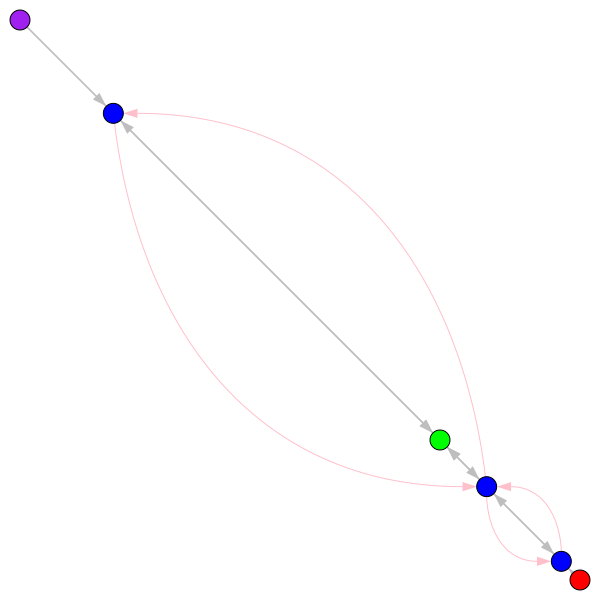

In [14]:
# fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g, target='plots/synthetic_graphs/synthetic_graph_1.svg')

In [15]:
[f.index for f in g.vs[[v.index for v in g.vs.select(type_eq='pt_node')]]]

[2, 3, 4]

In [16]:
# fig, ax = plt.subplots(figsize=(5,5))
# ig.plot(g, target='plots/synthetic_graphs/synthetic_graph_1.svg')

In [17]:
g.es['active'] = 1

In [18]:
# g.write_picklez('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/graph.picklez')
# g.write_picklez('/home/rico/Documents/thesis/experiments/base_data/graph_1.picklez')

# Census Data

In [19]:
data = {
    'neighborhood': V_O_attr['name'],
    'n_inh': [1000,100],
    'n_purple': [1000,0],
    'n_red': [0,100],
    'res_centroids': gpd.points_from_xy(V_O_attr['x'], V_O_attr['y'])
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC1,1000,1000,0,POINT (0.50000 0.50000)
1,RC2,100,0,100,POINT (3.50000 3.50000)


In [20]:
# gdf.to_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/census_data.geojson', driver='GeoJSON')
# gdf.to_file('/home/rico/Documents/thesis/experiments/base_data/census_data_1.geojson', driver='GeoJSON')

# Verification

In [23]:
from eptnr.rewards.egalitarian import EgalitarianTheilReward

from eptnr.analysis.full_problem_exploration import full_problem_exploration
from eptnr.plotting.solution_plotting import plot_full_problem_exploration

In [24]:
census_data = gdf.copy()
census_data['geometry'] = census_data['res_centroids']
census_data = census_data[['neighborhood', 'n_inh', 'n_purple', 'n_red', 'geometry']]
r = EgalitarianTheilReward(census_data=census_data, com_threshold=15)
r.evaluate(g)
g_trans = ig.read("/home/rico/Documents/thesis/experiments/base_data/graph_1.gml")

rewards = {}

n_edges = 2
possible_edges = it.combinations(g.es.select(type_ne='walk', active_eq=1), n_edges)

for ps in possible_edges:
    g_prime = g.copy()
    pseudo_index = '|'.join([f"{e.source_vertex['name']}->{e.target_vertex['name']}" for e in ps])
    pes = [e.index for e in ps]
    print(pes, pseudo_index)
    g_prime.es[pes]['active'] = 0
    rew = r.evaluate(g_prime)
    rewards[pseudo_index] = rew

[11, 12] PT1->PT2|PT2->PT1
[11, 13] PT1->PT2|PT2->PT3
[11, 14] PT1->PT2|PT3->PT2
[12, 13] PT2->PT1|PT2->PT3
[12, 14] PT2->PT1|PT3->PT2
[13, 14] PT2->PT3|PT3->PT2


INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:Possible states: [[[]], [[11], [12], [13], [14]], [[11, 12], [11, 13], [11, 14], [12, 13], [12, 14], [13, 14]], [[11, 12, 13], [11, 12, 14], [11, 13, 14], [12, 13, 14]]]
  0%|          | 0/4 [00:00<?, ?it/s]INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [] obtained rewards [91.38995616965695]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [11] obtained rewards [0.00031415065169471167, -inf, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [12] obtained rewards [0.00031415065169471167, 91.38995616965695, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [13] obtained rewards [0.00031415065169471167, 91.38995616965695, 91.38995616965695, -inf]
INFO:/home/rico/Documents/the

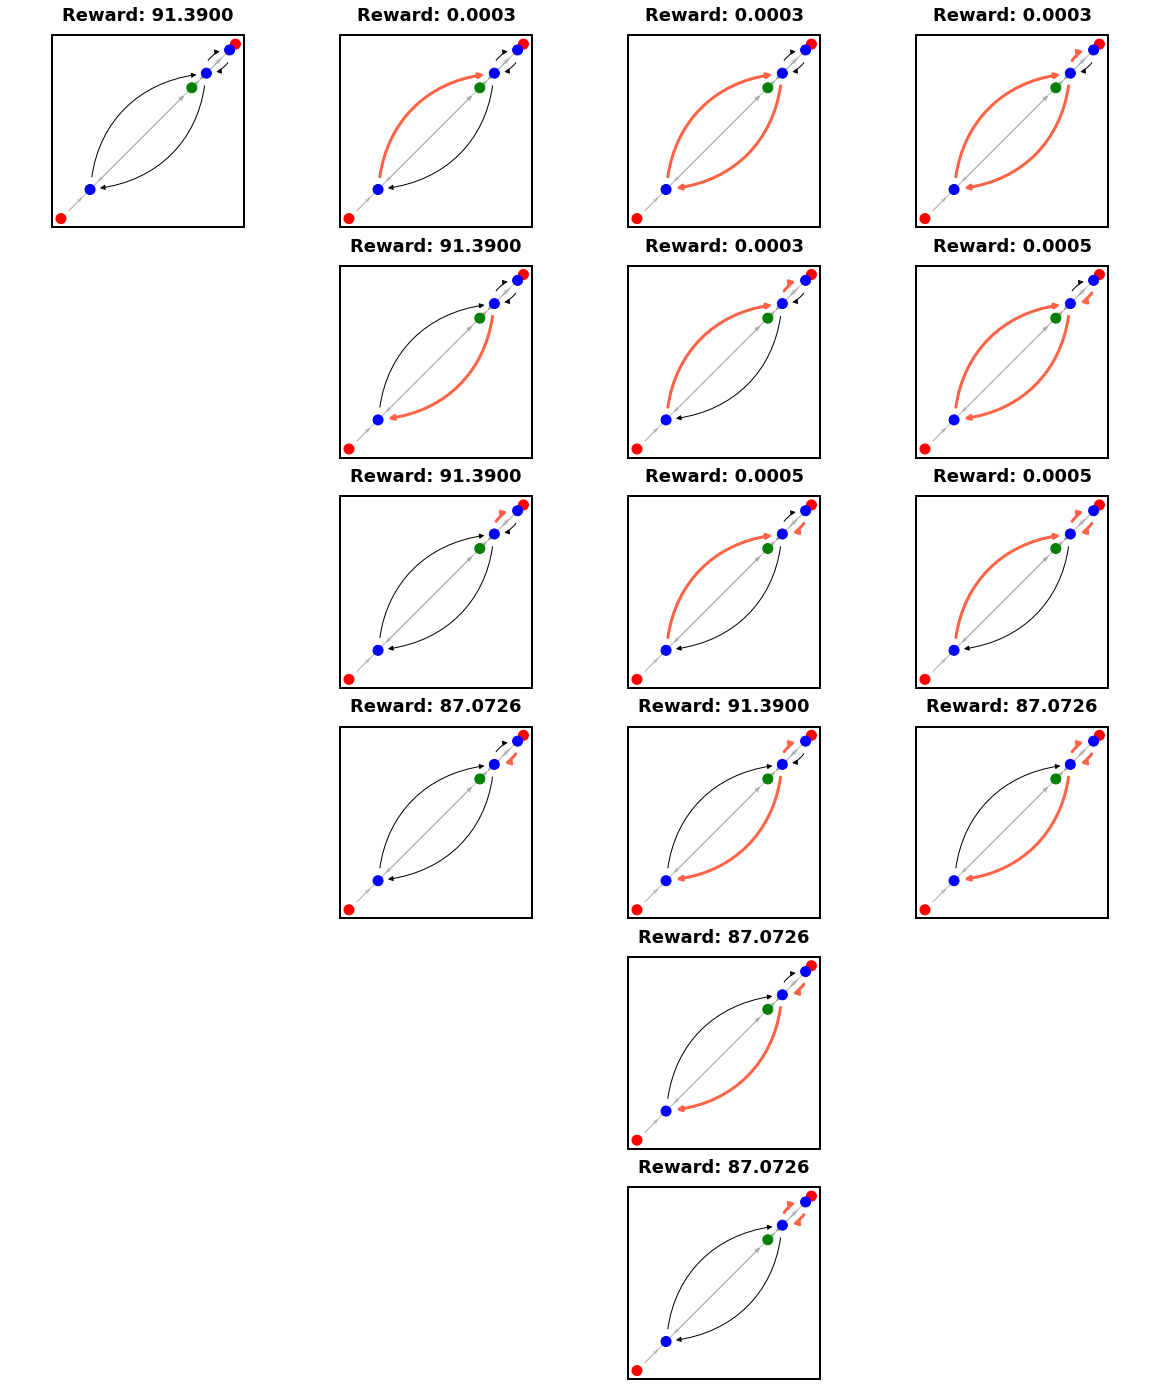

In [27]:
edge_types = list(np.unique(g.es['type']))
edge_types.remove('walk')

configurations, rewards = full_problem_exploration(g, r, edge_types)
fig, axs = plot_full_problem_exploration(base_graph=g, configurations=configurations, rewards=rewards)
plt.show()

INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:Possible states: [[[]], [[11], [12], [13], [14]], [[11, 12], [11, 13], [11, 14], [12, 13], [12, 14], [13, 14]], [[11, 12, 13], [11, 12, 14], [11, 13, 14], [12, 13, 14]]]
  0%|          | 0/4 [00:00<?, ?it/s]INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [] obtained rewards [91.38995616965684]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [11] obtained rewards [0.0004640799486669722, -inf, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [12] obtained rewards [0.0004640799486669722, 91.38995616965684, -inf, -inf]
INFO:/home/rico/Documents/thesis/eptnr_package/eptnr/analysis/full_problem_exploration.py:For state [13] obtained rewards [0.0004640799486669722, 91.38995616965684, 91.38995616965684, -inf]
INFO:/home/rico/Documents/thesis

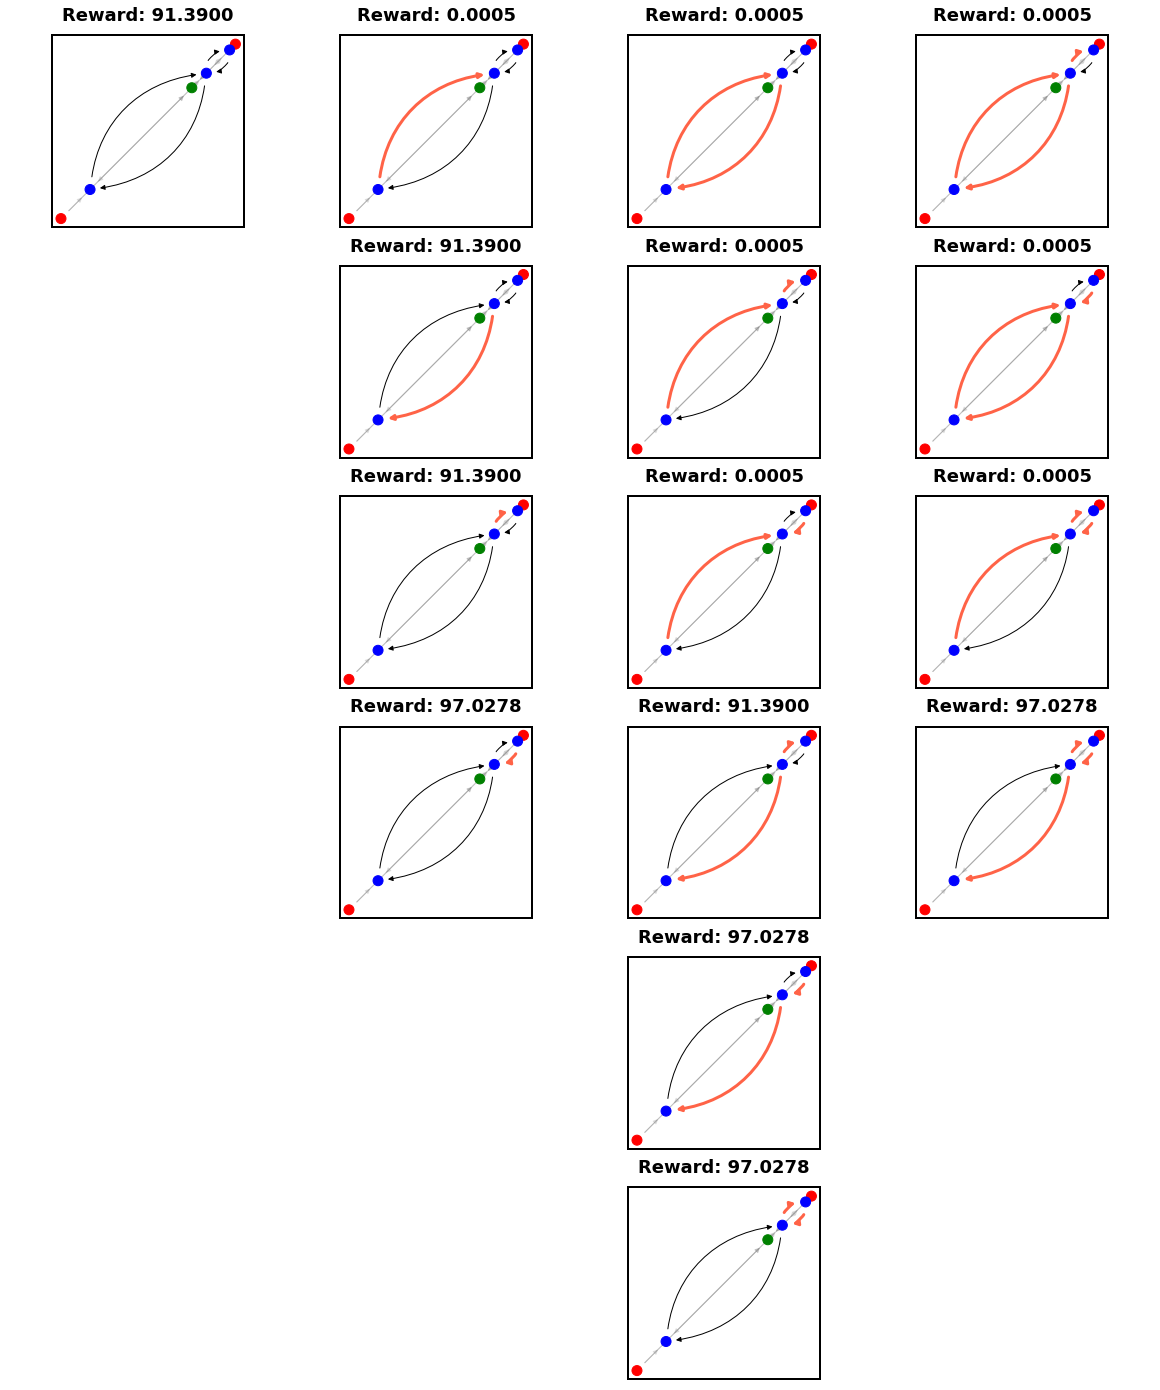

In [26]:
edge_types = list(np.unique(g.es['type']))
edge_types.remove('walk')

configurations, rewards = full_problem_exploration(g_trans, r, edge_types)
fig, axs = plot_full_problem_exploration(base_graph=g, configurations=configurations, rewards=rewards)
plt.show()